In [35]:
import pandas as pd
pd.options.plotting.backend = "plotly"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
import dask.dataframe as dd
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from dask.diagnostics import ProgressBar
ProgressBar().register()
import dask.multiprocessing
dask.config.set(scheduler='threads')
from tqdm.notebook import tqdm
import plotly.graph_objects as go 

In [36]:
import yaml
import base64
import os
cred = yaml.load(base64.b64decode(open('/home/jovyan/.secrets/tlinc-dremio.yaml.b64','r').read()),Loader=yaml.BaseLoader)
os.environ.update(cred)
cred = yaml.load(base64.b64decode(open('/home/jovyan/.secrets/tlinc-db-retail.yaml.b64','r').read()),Loader=yaml.BaseLoader)
os.environ.update({k:str(v) for k,v in cred.items()})

In [37]:
import pandas as pd
import numpy as np
from tl_datasource.dremio import get_async_dremio_connection, read_sql_to_pandas_aioodbc

In [38]:
# async with get_async_dremio_connection() as conn:
#     query = f'''
#         SELECT date_trunc ('HOUR' , cast(creation_date as timestamp)) as trx_hour, product_type,
#         count(*) as product_count,
#         sum(price) as price FROM "sp_IC".TR."stat_ancillaries_total"
#         where date_trunc ('DAY' , cast(creation_date as timestamp)) between '2021-08-01' and '2021-08-15'
#         group by date_trunc ('HOUR' , cast(creation_date as timestamp)), product_type
#     '''
#     df = await  read_sql_to_pandas_aioodbc(query, conn)

In [39]:
async with get_async_dremio_connection() as conn:
    query = f'''
        SELECT date_trunc ('HOUR' , cast(creation_date as timestamp)) as trx_hour,
        product_status, pos,
        count(*) as product_count,
        sum(total_price) as price FROM "sp_IC".TR."stat_product_ibe3"
        where date_trunc ('DAY' , cast(creation_date as timestamp)) between '2021-01-01' and '2021-10-31'
        and product_type='breakdown'
        group by date_trunc ('HOUR' , cast(creation_date as timestamp)), product_status, pos
    '''
    df2 = await  read_sql_to_pandas_aioodbc(query, conn)

In [40]:
# df = df.sort_values('trx_hour')
df2 = df2.sort_values('trx_hour')

In [26]:
#df.to_parquet('./stat_ancillaries_total_hourly_aug25-sep_07.parquet')

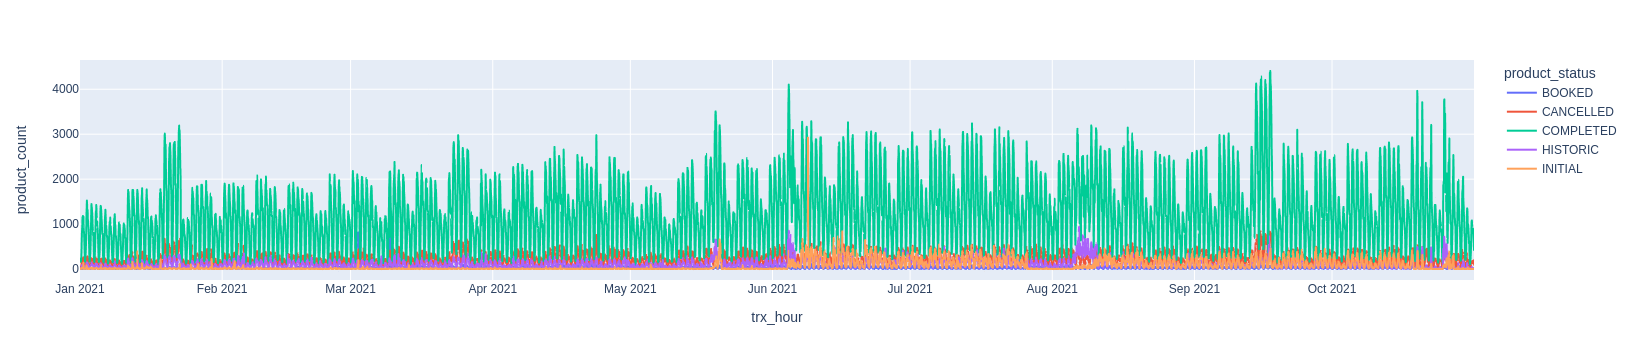

In [44]:
import plotly.express as px
px.line(df2.groupby(['trx_hour','product_status'])['product_count'].agg(sum).reset_index(), x='trx_hour', y='product_count', color='product_status')

In [41]:
df2.to_parquet('./stat_product_ibe3_breakdown_hourly_grouped_pos_productstatus_2021.parquet')

#  Daily data

In [45]:
async with get_async_dremio_connection() as conn:
    query = f'''
        SELECT date_trunc ('DAY' , cast(creation_date as timestamp)) as trx_day,
        product_status, pos,
        count(*) as product_count,
        sum(total_price) as price FROM "sp_IC".TR."stat_product_ibe3"
        where date_trunc ('DAY' , cast(creation_date as timestamp)) between '2021-01-01' and '2021-10-31'
        and product_type='breakdown'
        group by date_trunc ('DAY' , cast(creation_date as timestamp)), product_status, pos
    '''
    df2 = await  read_sql_to_pandas_aioodbc(query, conn)

In [48]:
df2 = df2.sort_values('trx_day')
df2.head()

,trx_day,product_status,pos,product_count,price
3752,2021-01-01,COMPLETED,IBE,2809,24728228.00
5172,2021-01-01,HISTORIC,MYB-iph,13,149358.00
2843,2021-01-01,HISTORIC,CCM-manual,9,46469.00
6860,2021-01-01,COMPLETED,IPH,2502,18931380.00
14815,2021-01-01,BOOKED,ANDROID,1,15621.00


In [49]:
df2.to_parquet('./stat_product_ibe3_breakdown_daily_grouped_pos_productstatus_2021.parquet')

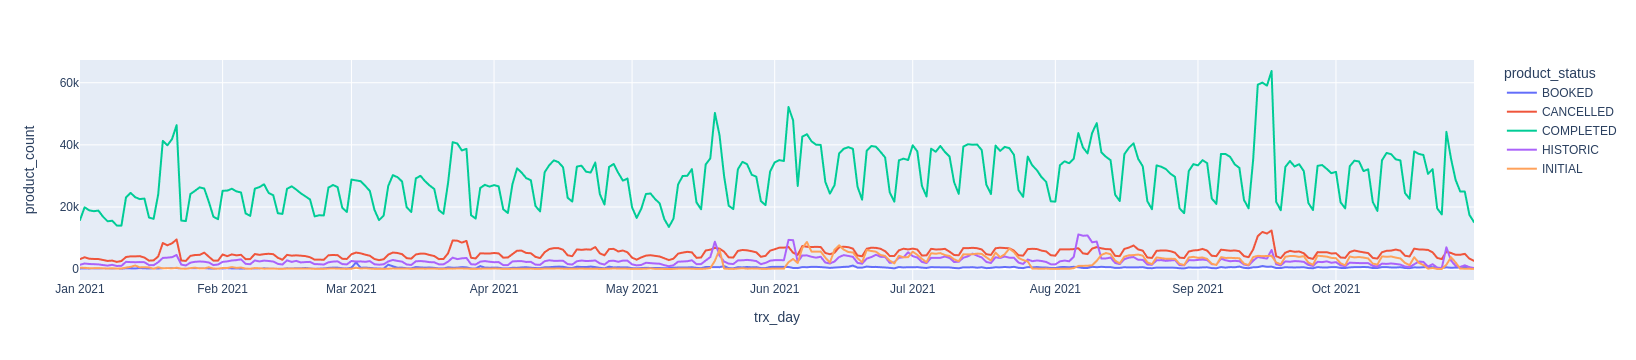

In [50]:
import plotly.express as px
px.line(df2.groupby(['trx_day','product_status'])['product_count'].agg(sum).reset_index(), x='trx_day', y='product_count', color='product_status')